In [1]:
"""
Predictive Rainfall Model for the Philippines
"""

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings

warnings.filterwarnings('ignore')


In [1]:
from rainfall_predictor import RainfallPredictor

# Initialize predictor
predictor = RainfallPredictor(
    monthly_data_path='../datasets/monthly.csv',        
)    

Monthly records loaded: 25071

Preprocessing data...
Monthly records: 24570
Cities with complete data: 135
Features: 11

Dataset: 24570 samples, 11 features
Features: month_sin, month_cos, latitude, longitude, temperature, humidity, air_pressure, oni_index, el_nino, la_nina, monthly_rainfall_lag_1


In [2]:
# Train and evaluate
results = predictor.cross_validate(cv_method='time_series')




TRAINING AND EVALUATION (Cross-Validation)

Using Time-Series Cross-Validation

XGBoost (Optimized)
----------------------------------------------------------------------
Fold 1: Train <= 2010, Test = 2011
   RMSE = 124.6882 mm | R² = 0.1956 | MAE = 89.5199 mm
Fold 2: Train <= 2011, Test = 2012
   RMSE = 106.0055 mm | R² = 0.4344 | MAE = 84.7922 mm
Fold 3: Train <= 2012, Test = 2013
   RMSE = 106.2532 mm | R² = 0.4836 | MAE = 75.0487 mm
Fold 4: Train <= 2013, Test = 2014
   RMSE = 113.5367 mm | R² = 0.4858 | MAE = 76.4769 mm
Fold 5: Train <= 2014, Test = 2015
   RMSE = 102.3779 mm | R² = 0.4552 | MAE = 71.2111 mm
Fold 6: Train <= 2015, Test = 2016
   RMSE = 94.4476 mm | R² = 0.6039 | MAE = 68.8484 mm
Fold 7: Train <= 2016, Test = 2017
   RMSE = 151.0739 mm | R² = 0.2354 | MAE = 77.4991 mm
Fold 8: Train <= 2017, Test = 2018
   RMSE = 112.6548 mm | R² = 0.5735 | MAE = 81.6688 mm
Fold 9: Train <= 2018, Test = 2019
   RMSE = 92.6024 mm | R² = 0.6140 | MAE = 62.9961 mm
Fold 10: Train <= 20


GENERATING VISUALIZATIONS
Saved: ../output\model_comparison.png

SUMMARY

Best Model: Gradient Boosting
  RMSE: 106.50 mm
  R²:   0.5123
  MAE:  73.12 mm

Comparison with previous SVR model:
  SVR (RBF): RMSE = 101.13 mm, R² = 0.5484
  Improvement: -5.3% better RMSE!



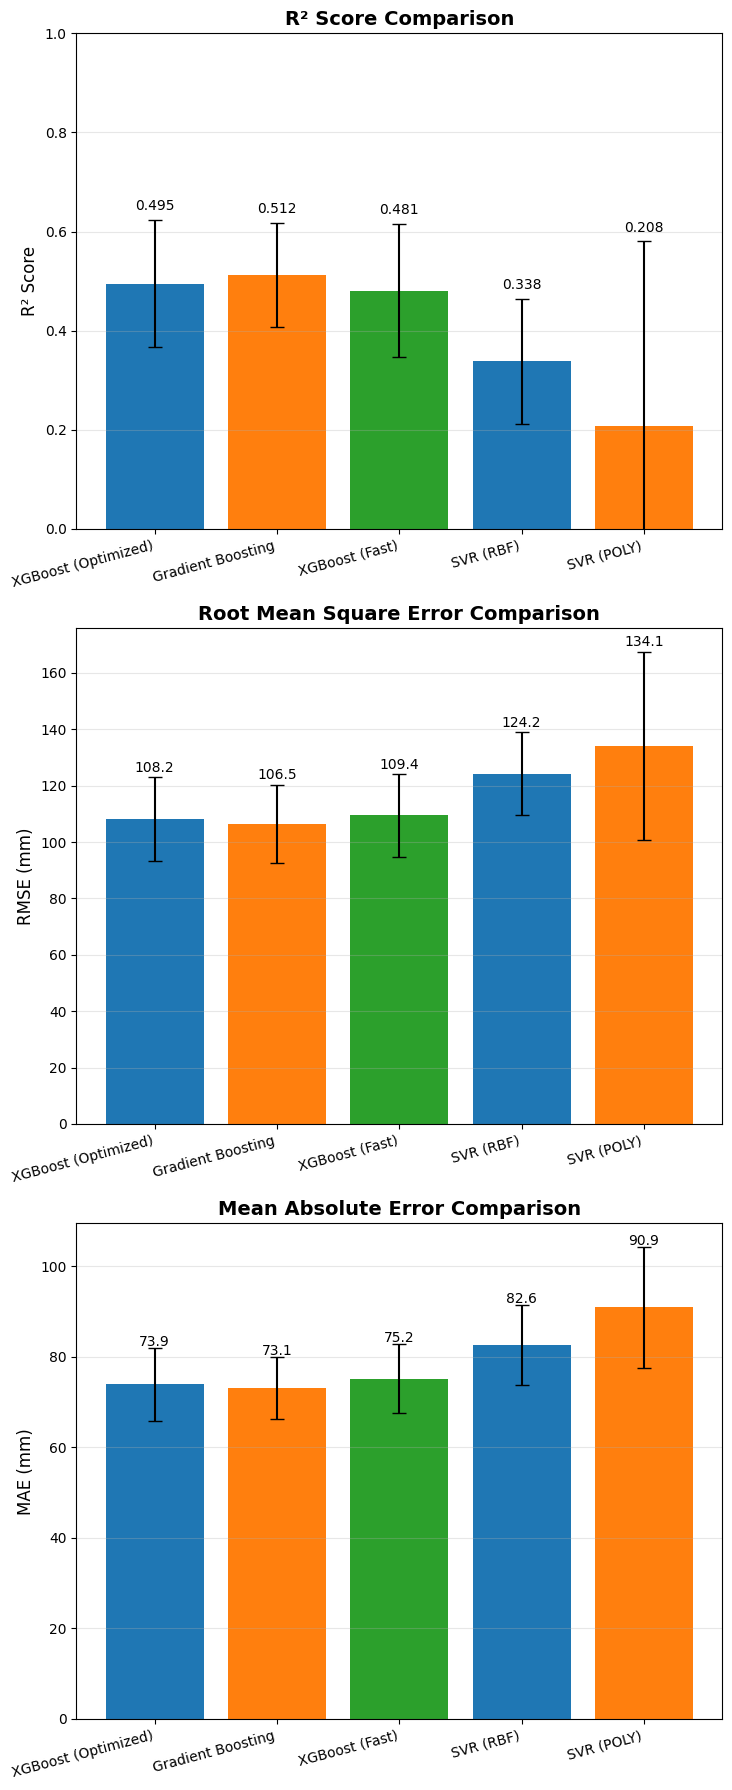

In [ ]:
# Generate plots
predictor.plot_results(results, results_dir='../output')

# Final summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

best_model = min(results.items(), key=lambda x: x[1]['rmse_mean'])
print(f"\nBest Model: {best_model[0]}")
print(f"  RMSE: {best_model[1]['rmse_mean']:.2f} mm")
print(f"  R²:   {best_model[1]['r2_mean']:.4f}")
print(f"  MAE:  {best_model[1]['mae_mean']:.2f} mm")

print("\nComparison with previous SVR model:")
print("  SVR (RBF): RMSE = 101.13 mm, R² = 0.5484")
improvement = ((101.13 - best_model[1]['rmse_mean']) / 101.13) * 100
print(f"  Improvement: {improvement:.1f}% better RMSE!")    
print("\n" + "="*70)

In [2]:
predictor.train_final_models()



TRAINING FINAL MODELS ON FULL DATASET

Training XGBoost (Optimized)...
Finished training XGBoost (Optimized)

Training Gradient Boosting...
Finished training Gradient Boosting

Training XGBoost (Fast)...
Finished training XGBoost (Fast)

Training SVR (RBF)...
Finished training SVR (RBF)

Training SVR (POLY)...
Finished training SVR (POLY)


{'XGBoost (Optimized)': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...),
 'Gradient Boosting': GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=4,
                           min_samples_split=10, n_estimators=300,
                           random_state=42, subsample=0.7),

In [3]:
predictor.plot_feature_importance(results_dir='../output')

Saved: ../output\xgboost_optimized_feature_importance.png
Saved: ../output\gradient_boosting_feature_importance.png
Saved: ../output\xgboost_fast_feature_importance.png
Skipping feature importance for SVR (RBF) (not supported)
Skipping feature importance for SVR (POLY) (not supported)


# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def custom_yearly_tscv(df, date_col='year'):
    """
    Generator for temporal CV by year.
    """
    years = df[date_col].values
    unique_years = np.sort(np.unique(years))
    
    for i in range(len(unique_years) - 1):
        train_idx = np.where(years <= unique_years[i])[0]
        test_idx = np.where(years == unique_years[i + 1])[0]
        yield train_idx, test_idx


def tune_xgboost(self, n_iter=25):
    """Hyperparameter tuning for XGBoost Optimized"""
    print("HYPERPARAMETER TUNING FOR XGBOOST (OPTIM)")
    
    # Features and target
    X = self.df_monthly[self.feature_columns].values
    y = self.df_monthly['monthly_rainfall'].values

    # Define parameter grid
    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'min_child_weight': [1, 3, 5, 7],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.3, 0.5],
        'reg_alpha': [0, 0.01, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2]
    }

    # Base model
    xgb_model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )

    # TimeSeriesSplit preserves temporal order
    tscv = custom_yearly_tscv(self.df_monthly, date_col='year')

    # Randomized Search
    randomized_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    randomized_search.fit(X, y)

    print("\nBest Hyperparameters Found:")
    print(randomized_search.best_params_)
    print(f"Best CV RMSE: {-randomized_search.best_score_:.4f} mm")

    # Update the optimized model with best params
    self.models['XGBoost (Optimized)'] = randomized_search.best_estimator_

    return randomized_search.best_params_

def tune_gradboost(self, n_iter=25):
    """Hyperparameter tuning for Gradient Boosting"""
    print("\n" + "="*70)
    print("HYPERPARAMETER TUNING FOR GRADBOOST")
    print("="*70)
    
    # Features and target
    X = self.df_monthly[self.feature_columns].values
    y = self.df_monthly['monthly_rainfall'].values

    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],          # number of trees
        'learning_rate': [0.05, 0.1, 0.2],       # step size for each boosting iteration
        'max_depth': [3, 4, 5, 6],               # max depth per tree
        'min_samples_split': [2, 5, 10],         # minimum samples to split an internal node
        'min_samples_leaf': [1, 2, 4],           # minimum samples at a leaf node
        'subsample': [0.7, 0.8, 1.0],            # fraction of samples for each tree
        'max_features': [None, 'sqrt', 'log2']   # number of features to consider for split
    }

    # Base model
    xgb_model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        random_state=42
    )

    # TimeSeriesSplit preserves temporal order
    tscv = custom_yearly_tscv(self.df_monthly, date_col='year')

    # Randomized Search
    randomized_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    randomized_search.fit(X, y)

    print("\nBest Hyperparameters Found:")
    print(randomized_search.best_params_)
    print(f"Best CV RMSE: {-randomized_search.best_score_:.4f} mm")

    # Update the optimized model with best params
    self.models['XGBoost (Optimized)'] = randomized_search.best_estimator_

    return randomized_search.best_params_

# Hyperparameter tuning
# Initialize predictor
predictor = PhilippinesRainfallPredictor(
    daily_data_path='datasets/daily/consolidated.csv',
    hourly_data_path='datasets/hourly/consolidated.csv',
    monthly_data_path='datasets/monthly.csv',
    oni_data_path='datasets/oni_indices.csv',
    cities_path='datasets/cities.csv'
)

# Load and preprocess
predictor.load_data()
predictor.preprocess_data()

# Tune XGBoost Optim
#best_params = tune_xgboost(predictor, n_iter=30)
best_params = tune_gradboost(predictor, n_iter=30)



LOADING DATA
Monthly records loaded: 25803

Adding cyclical time encoding (sin/cos for months)...
Monthly records: 23842
Cities with complete data: 131
Features: 11

HYPERPARAMETER TUNING FOR XGBOOST OPTIMIZED
Fitting 15 folds for each of 30 candidates, totalling 450 fits

Best Hyperparameters Found:
{'subsample': 0.7, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.05}
Best CV RMSE: 104.7076 mm


# Inspect the datasets

In [ ]:
daily_data_path='datasets/daily/consolidated.csv'
hourly_data_path='datasets/hourly/consolidated.csv'
cities_path='datasets/cities.csv'

df_monthly = None
models = {}
scaler = None
feature_columns = None

print("\n" + "="*70)
print("LOADING DATA")
print("="*70)

# Load cities
df_cities = pd.read_csv(cities_path)
df_cities.rename(columns={'city_name': 'city'}, inplace=True)
print(f"Cities: {len(df_cities)}")

# Load daily data
df_daily = pd.read_csv(daily_data_path)
df_daily.rename(columns={'city_name': 'city', 'datetime': 'date'}, inplace=True)
print(f"Daily records: {len(df_daily)}")

# Load hourly data
df_hourly = pd.read_csv(hourly_data_path)
df_hourly.rename(columns={
    'city_name': 'city', 
    'datetime': 'date',
    'relative_humidity_2m': 'humidity_2m'
}, inplace=True)
print(f"Hourly records: {len(df_hourly)}")

### PREPROCESS DATA 

print("\n" + "="*70)
print("PREPROCESSING DATA")
print("="*70)

# Convert dates
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_hourly['date'] = pd.to_datetime(df_hourly['date'])

# Aggregate hourly to daily
print("Aggregating hourly to daily...")
hourly_daily = df_hourly.groupby(['city', 'date']).agg({
    'humidity_2m': 'mean',
    'surface_pressure': 'mean'
}).reset_index()

# Merge with daily data
df_merged = df_daily.merge(hourly_daily, on=['city', 'date'], how='left')

# Aggregate to monthly
print("Aggregating daily to monthly...")
df_merged['year'] = df_merged['date'].dt.year
df_merged['month'] = df_merged['date'].dt.month

df_monthly = df_merged.groupby(['city', 'year', 'month']).agg({
    'temperature_2m_mean': 'mean',
    'humidity_2m': 'mean',
    'surface_pressure': 'mean',
    'precipitation_sum': 'sum'
}).reset_index()

df_monthly.rename(columns={
    'temperature_2m_mean': 'temperature',
    'humidity_2m': 'humidity',
    'surface_pressure': 'air_pressure',
    'precipitation_sum': 'monthly_rainfall'
}, inplace=True)

# Merge with coordinates
df_monthly = df_monthly.merge(
    df_cities[['city', 'latitude', 'longitude']], 
    on='city', 
    how='left'
)

# Add ENSO indices
def add_enso_indices(df, oni_data_path='datasets/oni_indices.csv'):
    """Add ENSO (El Niño Southern Oscillation) indices"""
    oni_data = pd.read_csv(oni_data_path, index_col='year').to_dict(orient='index')
    
    df['oni_index'] = df.apply(
        lambda row: oni_data.get(row['year'], [0]*12)[row['month']-1] 
        if row['year'] in oni_data else 0, 
        axis=1
    )
    df['el_nino'] = (df['oni_index'] > 0.5).astype(int)
    df['la_nina'] = (df['oni_index'] < -0.5).astype(int)

    return df

add_enso_indices(df_monthly)


LOADING DATA
Cities: 141
Daily records: 268473
Hourly records: 6443352

PREPROCESSING DATA
Aggregating hourly to daily...
Aggregating daily to monthly...


,city,year,month,temperature,humidity,air_pressure,monthly_rainfall,latitude,longitude,oni_index,el_nino,la_nina
0,Alaminos,2020,1,26.477419,81.290323,1012.325806,16.1,16.156111,119.981110,-0.5,0,0
1,Alaminos,2020,2,26.813793,73.551724,1014.275862,5.9,16.156111,119.981110,-0.4,0,0
2,Alaminos,2020,3,28.638710,81.838710,1011.783871,14.3,16.156111,119.981110,-0.1,0,0
3,Alaminos,2020,4,29.266667,87.433333,1011.143333,74.6,16.156111,119.981110,0.2,0,0
4,Alaminos,2020,5,29.341935,90.096774,1008.745161,341.0,16.156111,119.981110,0.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8878,Zamboanga City,2024,11,27.816667,88.400000,1008.520000,71.1,6.913480,122.069611,-0.4,0,0
8879,Zamboanga City,2024,12,26.854839,91.000000,1007.816129,184.6,6.913480,122.069611,-0.5,0,0
8880,Zamboanga City,2025,1,26.945161,89.903226,1008.854839,103.4,6.913480,122.069611,-0.6,0,1
8881,Zamboanga City,2025,2,27.250000,86.250000,1010.110714,63.6,6.913480,122.069611,-0.4,0,0


In [ ]:
df_monthly.to_csv('datasets/monthly.csv', index=False)

In [13]:
df_monthly.describe()

,year,month,temperature,humidity,air_pressure,monthly_rainfall,latitude,longitude,oni_index,el_nino,la_nina
count,8883.000000,8883.000000,8883.000000,921.000000,921.000000,8883.000000,8868.000000,8868.000000,8883.000000,8883.000000,8883.000000
mean,2022.142857,6.285714,26.740999,89.449082,1000.357585,233.442249,12.014342,122.675400,-0.122222,0.190476,0.333333
std,1.520916,3.507236,1.530665,5.009440,34.642430,163.362632,3.135951,1.793293,0.917509,0.392699,0.471431
min,2020.000000,1.000000,15.829032,68.548387,851.325806,0.300000,6.087220,118.733330,-1.600000,0.000000,0.000000
25%,2021.000000,3.000000,26.187097,86.700000,1007.506452,107.300000,9.515280,121.025398,-0.700000,0.000000,0.000000
50%,2022.000000,6.000000,26.903226,90.580645,1009.138710,216.900000,11.775280,122.801109,-0.300000,0.000000,0.000000
75%,2023.000000,9.000000,27.503226,93.032258,1010.276667,323.400000,14.570100,123.983330,0.200000,0.000000,1.000000
max,2025.000000,12.000000,31.676667,99.066667,1016.048276,1689.500000,18.198891,126.517502,2.100000,1.000000,1.000000


In [28]:
df_monthly.isna()
df_monthly.isna().sum()[df_monthly.isna().sum() > 0]


latitude     15
longitude    15
dtype: int64

In [29]:
missing_coords = df_monthly[
    df_monthly['latitude'].isna() | df_monthly['longitude'].isna()
]['city'].unique()

missing_coords


array(['Santiago'], dtype=object)

In [34]:
cities_2023 = set(df_monthly[df_monthly['year'] <= 2023]['city'].unique())
cities_2024 = set(df_monthly[df_monthly['year'] >= 2024]['city'].unique())

cities_both = cities_2023.intersection(cities_2024)
print(f"NUMBER OF CITIES EXISTING IN BOTH DATASETS: {len(cities_both)}")

cities_missing_before_2024 = cities_2024 - cities_2023
print(f"MISSING BEFORE 2024: {cities_missing_before_2024}")

cities_missing_after_2023 = cities_2023 - cities_2024
print(f"MISSING AFTER 2023: {cities_missing_after_2023}")


NUMBER OF CITIES EXISTING IN BOTH DATASETS: 136
MISSING BEFORE 2024: {'Santiago'}
MISSING AFTER 2023: {'Bago City'}


In [35]:
df_monthly[df_monthly['city'] == 'Bago City'].describe()

,year,month,temperature,humidity,air_pressure,monthly_rainfall,latitude,longitude,oni_index,el_nino,la_nina
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.00000,4.800000e+01,48.000000,48.000000,48.000000
mean,2021.500000,6.500000,27.303958,86.433414,1009.316807,175.656250,10.53333,1.228333e+02,-0.222917,0.166667,0.416667
std,1.129865,3.488583,0.695420,2.916370,0.914146,113.197641,0.00000,1.436124e-14,0.957443,0.376622,0.498224
min,2020.000000,1.000000,25.861290,76.900000,1007.845161,6.900000,10.53333,1.228333e+02,-1.600000,0.000000,0.000000
25%,2020.750000,3.750000,27.024654,85.050000,1008.773978,79.000000,10.53333,1.228333e+02,-0.900000,0.000000,0.000000
50%,2021.500000,6.500000,27.248387,86.753226,1009.095161,177.100000,10.53333,1.228333e+02,-0.500000,0.000000,0.000000
75%,2022.250000,9.250000,27.517930,88.620968,1009.694167,260.750000,10.53333,1.228333e+02,0.100000,0.000000,1.000000
max,2023.000000,12.000000,29.516667,90.935484,1012.544828,435.900000,10.53333,1.228333e+02,2.100000,1.000000,1.000000


In [36]:
# Drop missing values
initial_count = len(df_monthly)
df_monthly = df_monthly.dropna()

In [37]:
df_monthly.describe()

,year,month,temperature,humidity,air_pressure,monthly_rainfall,latitude,longitude,oni_index,el_nino,la_nina
count,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000
mean,2022.139378,6.286874,26.740416,88.986924,1003.247961,233.494452,12.014342,122.675400,-0.122767,0.190347,0.333784
std,1.519756,3.506976,1.531093,4.961026,18.810297,163.238752,3.135951,1.793293,0.917704,0.392597,0.471590
min,2020.000000,1.000000,15.829032,66.580645,850.890000,0.300000,6.087220,118.733330,-1.600000,0.000000,0.000000
25%,2021.000000,3.000000,26.187097,86.483871,1005.316667,107.600000,9.515280,121.025398,-0.700000,0.000000,0.000000
50%,2022.000000,6.000000,26.903280,90.225806,1008.473333,217.000000,11.775280,122.801109,-0.300000,0.000000,0.000000
75%,2023.000000,9.000000,27.503226,92.483037,1009.864343,323.425000,14.570100,123.983330,0.200000,0.000000,1.000000
max,2025.000000,12.000000,31.676667,99.838710,1016.424138,1689.500000,18.198891,126.517502,2.100000,1.000000,1.000000


In [ ]:
# Drop missing values
initial_count = len(df_monthly)
df_monthly = df_monthly.dropna()


# Keep only cities with complete 48 months
city_counts = df_monthly.groupby('city').size()
complete_cities = city_counts[city_counts == NUM_MONTHS].index
df_monthly = df_monthly[df_monthly['city'].isin(complete_cities)]

print(f"Monthly records: {len(df_monthly)}")
print(f"Cities with complete data: {len(complete_cities)}")
print(f"Features: {len(df_monthly.columns) - 4}")

Monthly records: 8316
Cities with complete data: 132
Features: 8
